In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision import transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/train', transform=transform)
val_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
num_classes = len(train_dataset.classes)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                num_labels=num_classes,
                                               ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


In [5]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of trainable parameters: 2307


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(),
                       lr=0.00002,
                       weight_decay=0.001)

In [7]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_bar = tqdm(train_loader, desc="Training")
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_bar.set_postfix(loss=running_loss / total_train, accuracy=train_accuracy)

    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_accuracy = 100 * correct_val / total_val
            val_bar.set_postfix(loss=val_loss / total_val, accuracy=val_accuracy)

    # Calculate average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {avg_train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {avg_val_accuracy:.2f}%")

end_time = time.time()

Epoch [1/30]


Training:   0%|                                                                                | 0/127 [00:00<?, ?it/s]C:\Users\cnky2\anaconda3\envs\manu\Lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
Training: 100%|██████████████████████████████████████████| 127/127 [01:11<00:00,  1.78it/s, accuracy=56.3, loss=0.0291]


Epoch [1/30] - Train Loss: 0.9318, Train Accuracy: 56.29%, Val Loss: 0.8404, Val Accuracy: 63.93%
Epoch [2/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=70.6, loss=0.0225]


Epoch [2/30] - Train Loss: 0.7206, Train Accuracy: 70.59%, Val Loss: 0.6964, Val Accuracy: 76.97%
Epoch [3/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=78.7, loss=0.0192]


Epoch [3/30] - Train Loss: 0.6127, Train Accuracy: 78.73%, Val Loss: 0.6080, Val Accuracy: 79.87%
Epoch [4/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:10<00:00,  1.81it/s, accuracy=81.4, loss=0.0168]


Epoch [4/30] - Train Loss: 0.5387, Train Accuracy: 81.37%, Val Loss: 0.5385, Val Accuracy: 83.25%
Epoch [5/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:10<00:00,  1.81it/s, accuracy=83.9, loss=0.0151]


Epoch [5/30] - Train Loss: 0.4826, Train Accuracy: 83.85%, Val Loss: 0.4844, Val Accuracy: 84.54%
Epoch [6/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:11<00:00,  1.79it/s, accuracy=85.9, loss=0.0137]


Epoch [6/30] - Train Loss: 0.4374, Train Accuracy: 85.90%, Val Loss: 0.4403, Val Accuracy: 86.80%
Epoch [7/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=87.7, loss=0.0125]


Epoch [7/30] - Train Loss: 0.3998, Train Accuracy: 87.74%, Val Loss: 0.4061, Val Accuracy: 88.24%
Epoch [8/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=89.1, loss=0.0115]


Epoch [8/30] - Train Loss: 0.3685, Train Accuracy: 89.10%, Val Loss: 0.3725, Val Accuracy: 89.37%
Epoch [9/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=90.3, loss=0.0107]


Epoch [9/30] - Train Loss: 0.3410, Train Accuracy: 90.28%, Val Loss: 0.3439, Val Accuracy: 90.98%
Epoch [10/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.81it/s, accuracy=91.3, loss=0.00991]


Epoch [10/30] - Train Loss: 0.3169, Train Accuracy: 91.26%, Val Loss: 0.3218, Val Accuracy: 90.98%
Epoch [11/30]


Training: 100%|███████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=92, loss=0.00926]


Epoch [11/30] - Train Loss: 0.2961, Train Accuracy: 91.98%, Val Loss: 0.2986, Val Accuracy: 92.43%
Epoch [12/30]


Training: 100%|███████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=93, loss=0.00866]


Epoch [12/30] - Train Loss: 0.2772, Train Accuracy: 92.96%, Val Loss: 0.2806, Val Accuracy: 93.40%
Epoch [13/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=93.6, loss=0.00815]


Epoch [13/30] - Train Loss: 0.2608, Train Accuracy: 93.63%, Val Loss: 0.2629, Val Accuracy: 93.40%
Epoch [14/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=94.6, loss=0.00767]


Epoch [14/30] - Train Loss: 0.2454, Train Accuracy: 94.56%, Val Loss: 0.2479, Val Accuracy: 94.04%
Epoch [15/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=95.2, loss=0.00724]


Epoch [15/30] - Train Loss: 0.2316, Train Accuracy: 95.15%, Val Loss: 0.2340, Val Accuracy: 94.36%
Epoch [16/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=95.7, loss=0.00685]


Epoch [16/30] - Train Loss: 0.2191, Train Accuracy: 95.72%, Val Loss: 0.2205, Val Accuracy: 94.85%
Epoch [17/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=96.3, loss=0.00649]


Epoch [17/30] - Train Loss: 0.2076, Train Accuracy: 96.31%, Val Loss: 0.2094, Val Accuracy: 95.33%
Epoch [18/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=96.7, loss=0.00616]


Epoch [18/30] - Train Loss: 0.1972, Train Accuracy: 96.70%, Val Loss: 0.1984, Val Accuracy: 95.97%
Epoch [19/30]


Training: 100%|███████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=97, loss=0.00586]


Epoch [19/30] - Train Loss: 0.1874, Train Accuracy: 96.97%, Val Loss: 0.1893, Val Accuracy: 96.14%
Epoch [20/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=97.5, loss=0.00557]


Epoch [20/30] - Train Loss: 0.1781, Train Accuracy: 97.54%, Val Loss: 0.1814, Val Accuracy: 96.46%
Epoch [21/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:11<00:00,  1.78it/s, accuracy=97.8, loss=0.00531]


Epoch [21/30] - Train Loss: 0.1700, Train Accuracy: 97.78%, Val Loss: 0.1715, Val Accuracy: 97.75%
Epoch [22/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=98.3, loss=0.00507]


Epoch [22/30] - Train Loss: 0.1621, Train Accuracy: 98.28%, Val Loss: 0.1634, Val Accuracy: 97.75%
Epoch [23/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.81it/s, accuracy=98.3, loss=0.00484]


Epoch [23/30] - Train Loss: 0.1548, Train Accuracy: 98.33%, Val Loss: 0.1571, Val Accuracy: 97.75%
Epoch [24/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=98.5, loss=0.00462]


Epoch [24/30] - Train Loss: 0.1478, Train Accuracy: 98.55%, Val Loss: 0.1494, Val Accuracy: 97.75%
Epoch [25/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=98.8, loss=0.00443]


Epoch [25/30] - Train Loss: 0.1416, Train Accuracy: 98.79%, Val Loss: 0.1448, Val Accuracy: 98.07%
Epoch [26/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=98.8, loss=0.00424]


Epoch [26/30] - Train Loss: 0.1356, Train Accuracy: 98.79%, Val Loss: 0.1389, Val Accuracy: 98.23%
Epoch [27/30]


Training: 100%|███████████████████████████████████████████| 127/127 [01:10<00:00,  1.79it/s, accuracy=99, loss=0.00406]


Epoch [27/30] - Train Loss: 0.1298, Train Accuracy: 99.02%, Val Loss: 0.1311, Val Accuracy: 98.39%
Epoch [28/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=99.1, loss=0.00389]


Epoch [28/30] - Train Loss: 0.1245, Train Accuracy: 99.14%, Val Loss: 0.1266, Val Accuracy: 98.71%
Epoch [29/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=99.2, loss=0.00373]


Epoch [29/30] - Train Loss: 0.1195, Train Accuracy: 99.19%, Val Loss: 0.1220, Val Accuracy: 98.55%
Epoch [30/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:10<00:00,  1.80it/s, accuracy=99.2, loss=0.00359]
                                                                                                                       

Epoch [30/30] - Train Loss: 0.1148, Train Accuracy: 99.21%, Val Loss: 0.1163, Val Accuracy: 98.71%


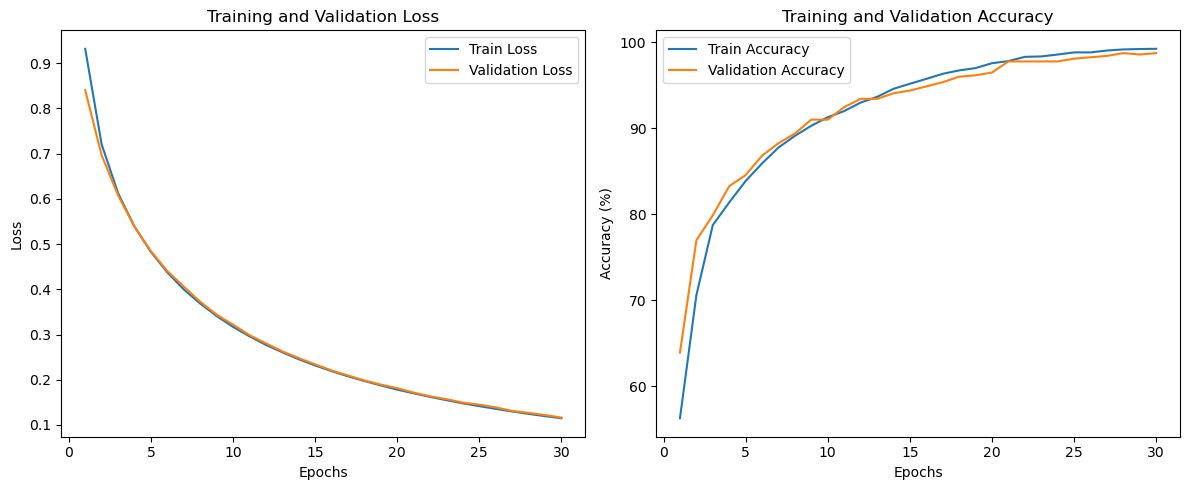

In [8]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
(end_time - start_time) / 60

41.894322804609935